In [21]:
# import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import nlp libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.classify import NaiveBayesClassifier
from nltk.classify.util import accuracy
from nltk.text import Text

In [2]:
# load data
df = pd.read_csv('imdb_reviews1.csv')
print(df.head())

# remove lines with spaces in rate or max_rate
df = df.dropna(subset=['rate', 'max_rate'])
def convert_to_float(value):
    if isinstance(value, str) and '/' in value:
        value = value.strip().replace("/", "")
        return float(value.split('/')[0])
    try:
        return float(value)
    except (ValueError, TypeError):
        return np.nan

# convert str to float
df['rate'] = df['rate'].apply(convert_to_float)
df['max_rate'] = df['max_rate'].apply(convert_to_float)

# remove lines with None value
df = df.dropna(subset=['rate', 'max_rate'])
# create a new column with positive and negative value. If rate > 5 is posituve else negtive
df['sentiment'] = df['rate'].apply(lambda x: 'positive' if x > df['max_rate'].max()/2 else 'negative')
print("dataset afte processing")
df.head()

                                             comment          date  rate  \
0  If you want a movie full of explosions and fig...  May 26, 2019   8.0   
1  Transformers is a great movie with a pretty go...   Oct 1, 2013   8.0   
2  No, it is not a smart movie, or a well written...  Aug 21, 2007   8.0   
3  Sometimes (probably more often than not in thi...   Mar 7, 2017   9.0   
4  I expected this to be an action movie only, bu...  Jun 28, 2015   NaN   

  max_rate  
0      /10  
1      /10  
2      /10  
3      /10  
4      NaN  
dataset afte processing


,comment,date,rate,max_rate,sentiment
0,If you want a movie full of explosions and fig...,"May 26, 2019",8.0,10.0,positive
1,Transformers is a great movie with a pretty go...,"Oct 1, 2013",8.0,10.0,positive
2,"No, it is not a smart movie, or a well written...","Aug 21, 2007",8.0,10.0,positive
3,Sometimes (probably more often than not in thi...,"Mar 7, 2017",9.0,10.0,positive
5,"When I saw Transformers, I will admit I wasn't...","Nov 11, 2009",7.0,10.0,positive



  Analysis of the review dataset:
--------------------------------
- Total number of reviews: 1991
- Positive feedback: 1383 (69.5%)
- Negative feedback: 608 (30.5%)
--------------------------------

count    1991.000000
mean        6.767454
std         3.010478
min         1.000000
25%         5.000000
50%         8.000000
75%         9.000000
max        10.000000
Name: rate, dtype: float64


Text(0, 0.5, 'frequency')

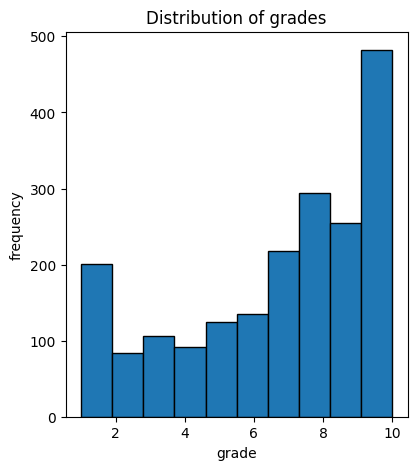

In [3]:
total_reviews = len(df)
positive = df['sentiment'].value_counts()['positive']
negative = df['sentiment'].value_counts()['negative'] if 'negative' in df['sentiment'].values else 0
positive_ratio = positive / total_reviews

print(f"""
  Analysis of the review dataset:
--------------------------------
- Total number of reviews: {total_reviews}
- Positive feedback: {positive} ({positive_ratio:.1%})
- Negative feedback: {negative} ({(1-positive_ratio):.1%})
--------------------------------
""")

print(df['rate'].describe())
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 2)
df['rate'].plot(kind='hist', bins=10, edgecolor='black')
plt.title('Distribution of grades')
plt.xlabel('grade')
plt.ylabel('frequency')

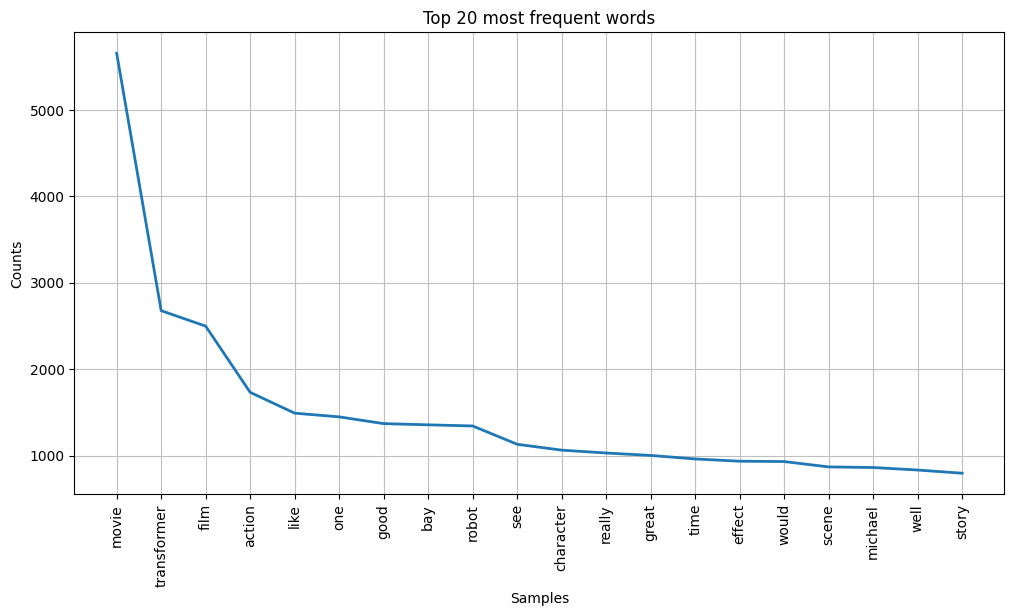

In [9]:
def clean_text(text):
    # NaN test and numerical values
    if pd.isna(text) or isinstance(text, (int, float)):
        return []  # return an empty list
    
    # Convert to string and clean up
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    text = str(text).lower()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens 
              if token.isalpha() and token not in stop_words]
    return tokens


# Create a dictionary of the most frequent words
all_words = []
for text in df['comment']:
    all_words += clean_text(text)
freq_dist = nltk.FreqDist(all_words)
top_words = [word for word, _ in freq_dist.most_common(2000)]
plt.figure(figsize=(12, 6))
freq_dist.plot(20, title='Top 20 most frequent words')
plt.show()


In [12]:

# text vectorization
def text_to_features(text):
    words = set(clean_text(text))
    features = {}
    for word in top_words:
        features[f'contains({word})'] = (word in words)
    return features

# Creating a dataset for NLTK
labeled_data = [(text_to_features(row['comment']), row['sentiment']) 
               for _, row in df.iterrows()]

# split on test and train data
train_size = int(0.8 * len(labeled_data))
train_set, test_set = labeled_data[:train_size], labeled_data[train_size:]

In [13]:
#  Training a Naive Bayes classifier
classifier = NaiveBayesClassifier.train(train_set)

# Assessment of accuracy
print(f"Accuracy: {accuracy(classifier, test_set):.2%}")

Accuracy: 70.68%


In [18]:
# most informative words
classifier.show_most_informative_features(20)

# error matrix
from collections import defaultdict
confusion = defaultdict(int)
for (features, label) in test_set:
    predicted = classifier.classify(features)
    confusion[(label, predicted)] += 1

print("\nConfusion Matrix:")
print("Actual\\Predicted | Negative | Positive")
print("-----------------+----------+----------")
print(f"Negative         | {confusion[('negative', 'negative')]:^8} | {confusion[('negative', 'positive')]:^8}")
print(f"Positive         | {confusion[('positive', 'negative')]:^8} | {confusion[('positive', 'positive')]:^8}")

Most Informative Features
     contains(redeeming) = True           negati : positi =     16.4 : 1.0
     contains(painfully) = True           negati : positi =     10.8 : 1.0
       contains(garbage) = True           negati : positi =     10.0 : 1.0
        contains(insult) = True           negati : positi =      9.6 : 1.0
          contains(mess) = True           negati : positi =      9.5 : 1.0
           contains(dog) = True           negati : positi =      9.1 : 1.0
          contains(pile) = True           negati : positi =      7.9 : 1.0
         contains(utter) = True           negati : positi =      7.9 : 1.0
      contains(disaster) = True           negati : positi =      7.7 : 1.0
        contains(proper) = True           negati : positi =      7.4 : 1.0
         contains(proof) = True           negati : positi =      6.9 : 1.0
     contains(delivered) = True           positi : negati =      6.7 : 1.0
         contains(awful) = True           negati : positi =      6.6 : 1.0

<Figure size 1200x600 with 0 Axes>

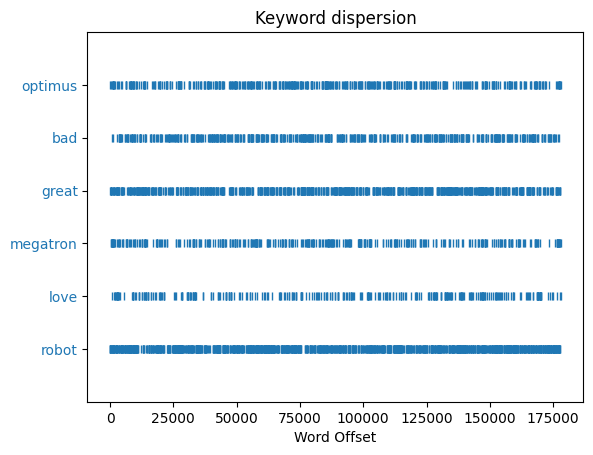

In [19]:
from nltk.draw.dispersion import dispersion_plot
target_words = ['optimus', 'bad', 'great', 'megatron', 'love', 'robot']
plt.figure(figsize=(12, 6))
dispersion_plot(all_words, target_words, title='Keyword dispersion')
plt.show()

In [22]:
nltk_text = Text(all_words)
print("Examples of word usage 'good':")
nltk_text.concordance('good', width=100, lines=5)

print("\nExamples of word usage 'bad':")
nltk_text.concordance('bad', width=100, lines=5)

Examples of word usage 'good':
Displaying 5 of 1370 matches:
scene right cool transformer great movie pretty good storyline decent bit long two half hour fly enj
 shia labeouf lot although attractive megan fox good actress feel like say line probably would got a
ss feel like say line probably would got acting good looking definitely think better actress like em
ng smart movie well written one movie certainly good one hardly deny fairly good pretty obvious stun
one movie certainly good one hardly deny fairly good pretty obvious stunning visuals brilliant editi

Examples of word usage 'bad':
Displaying 5 of 592 matches:
tted movie could go good thing bumblebee frenzy bad thing anthony anderson family forgotten barrica
ty screen time autobot leader shame decepticons bad guy even megatron would definitely benefited mo
urn sequel movie really awesome ca say anything bad great plot great action great movie great four 
decepticons man cool opening scene particularly bad megan fox hot mean ca 